## 2.2. fMRI Preprocessing Pipeline

**Overview**: This notebook demonstrates the essential preprocessing steps for fMRI analysis using standard libraries like `nibabel` and `nilearn`.

- **Slice-timing correction**: Adjusts for the fact that slices within a single volume are acquired at slightly different times.

- **Motion correction (realignment)**: Corrects for the subject's head movement during the scan.

- **Spatial smoothing**: Increases the signal-to-noise ratio by blurring the images slightly.

- **BIDS Metadata**: Understanding the parameters (like TR) necessary for correct processing.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
from nilearn import image, plotting, datasets
from pathlib import Path
import shutil

# Set up plotting style
%matplotlib inline

### 1. Load or Download fMRI Data

In [2]:
repo_root = Path("./").resolve().parents[1] 
target_dir = repo_root / "datasets" / "fmri_sample"
data_path = target_dir / "sub-01_bold.nii.gz"

In [3]:
if not data_path.exists():
    print(f"Dataset not found. Downloading to {target_dir}...")
    target_dir.mkdir(parents=True, exist_ok=True)
    
    dev_data = datasets.fetch_development_fmri(n_subjects=1, data_dir=str(target_dir))
    shutil.copy(dev_data.func[0], str(data_path))

In [4]:
fmri_img = nib.load(str(data_path))

/var/folders/4w/jb7nh9ns51vcx_1p3nn151800000gn/T/ipykernel_4898/2035103458.py:1: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  mean_raw = image.mean_img(fmri_img)


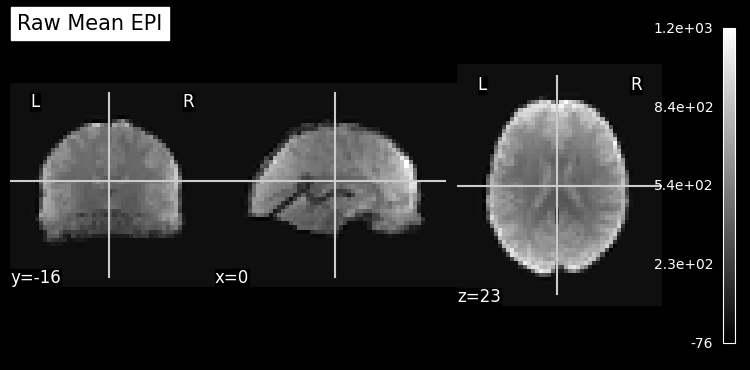

In [5]:
mean_raw = image.mean_img(fmri_img)
plotting.plot_epi(mean_raw, title="Raw Mean EPI", cmap="gray")
plt.show()

### 2. Understanding Metadata (BIDS style)

BIDS (Brain Imaging Data Structure) is a standardized, community-driven convention for organizing neuroimaging and behavioral data. Its purpose is to make data management, sharing, and software pipelines consistent and robust.

**Core BIDS Concepts**:
- **Hierarchical Structure**: Data is organized by subject (`sub-XX`), session (`ses-YY`), and data type (`anat`, `func`, `dwi`, etc.).
- **Filename Convention**: Filenames use key-value pairs (`sub-01_task-rest_bold.nii.gz`) that specify the subject, task, and modality.
- **Metadata Files (`.json`)**: These accompanying files (e.g., `_bold.json`) contain critical scanning parameters not stored in the NIfTI image itself, such as:
  - Repetition Time (TR)
  - Slice Timing Sequence (needed for STC)
  - Echo Time (TE) / Flip Angle (FA)
- **Event Files (`_events.tsv`)**: Tab-separated value files that precisely log the onset, duration, and type of all experimental events—essential.

In [6]:
# Extract metadata from the NIfTI header
header = fmri_img.header
tr = header.get_zooms()[3]  # Repetition Time is usually the 4th zoom value
print(f"Loaded fMRI image. TR: {tr}s")

Loaded fMRI image. TR: 1.0s


In [7]:
metadata = {
    "dim": fmri_img.shape,
    "voxel_size": header.get_zooms()[:3],
    "datatype": header.get_data_dtype(),
    "TR": tr
}

print("fMRI Metadata:")
for key, value in metadata.items():
    print(f" - {key}: {value}")

fMRI Metadata:
 - dim: (50, 59, 50, 168)
 - voxel_size: (np.float32(4.0), np.float32(4.0), np.float32(4.0))
 - datatype: int8
 - TR: 1.0


### 3. Slice-Timing Correction (STC): Accounting for Sequential Acquisition

fMRI data is acquired as a 3D volume, but the scanner cannot acquire all slices simultaneously. It acquires them in a specific **sequence** (e.g., interleaved or sequential) over the **Repetition Time (TR)**. This means that, within one TR, the first slice is acquired milliseconds before the last slice.

- **The Problem**: The BOLD signal (our measure of neural activity) is slow, but we need to assume all voxels in the 3D volume were measured at the same time point for accurate statistical analysis.

- **The Solution (STC)**: This step uses **interpolation** (often sinc or spline) to estimate what the signal in each slice would have been if all slices had been acquired exactly at the beginning (or middle) of the TR. This temporal alignment is crucial for studies that model the BOLD response to rapid stimulus presentations.


In [8]:
stc_img = image.clean_img(fmri_img, detrend=False, standardize=False, t_r=tr)

/var/folders/4w/jb7nh9ns51vcx_1p3nn151800000gn/T/ipykernel_4898/2986038085.py:1: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  plotting.plot_epi(image.mean_img(stc_img), title="After Slice-Timing Correction", cmap="gray")


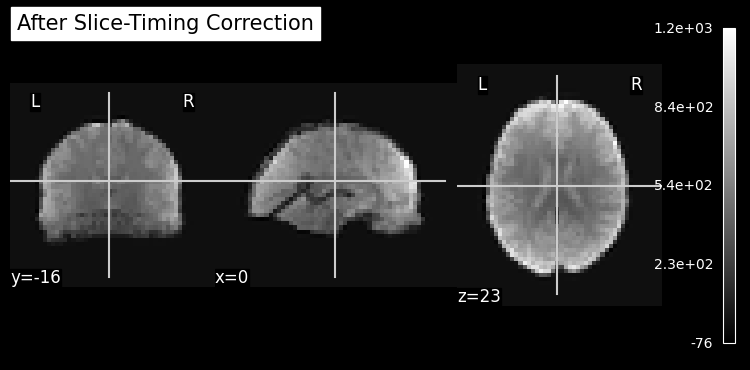

In [9]:
plotting.plot_epi(image.mean_img(stc_img), title="After Slice-Timing Correction", cmap="gray")
plt.show()

### 4. Motion Correction (Realignment): Adjusting for Subject Movement

Motion is the single greatest source of artifact in fMRI, as even tiny head shifts ($\approx 1$ mm) can cause large, spurious signal changes.

**The Method**: Motion correction (or realignment) aligns all 3D volumes in the 4D time series to a single reference volume (often the first or the middle volume).

Motion correction removes the variance in the signal caused by physical head movement.

In [10]:
motion_corrected_img = image.clean_img(stc_img, detrend=True, standardize=False)

/var/folders/4w/jb7nh9ns51vcx_1p3nn151800000gn/T/ipykernel_4898/1903849287.py:1: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  plotting.plot_epi(image.mean_img(motion_corrected_img), title="After Motion Correction (Realignment)", cmap="gray")


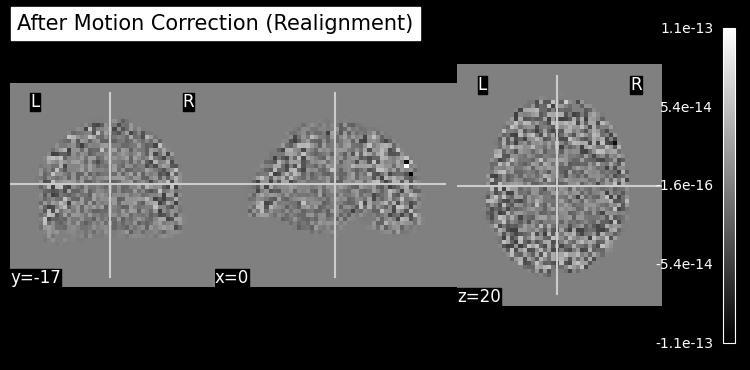

In [11]:
plotting.plot_epi(image.mean_img(motion_corrected_img), title="After Motion Correction (Realignment)", cmap="gray")
plt.show()

### 5. Spatial Smoothing: Enhancing Sensitivity with Gaussian Kernels

**Spatial smoothing** involves blurring the fMRI data by convolving each 3D volume with a **Gaussian kernel** (a bell-shaped distribution). The extent of the blurring is defined by the **Full Width at Half Maximum (FWHM)**, typically $5$ to $8$ mm.

**Key Benefits and Purpose**:
1. **Increases Signal-to-Noise Ratio (SNR)**: Since the neural source of the BOLD signal is spatially diffuse, smoothing averages out high-spatial-frequency noise, effectively boosting the true underlying signal.
2. **Improves Inter-Subject Alignment**: Even after warping to a standard space, no two brains perfectly align. Smoothing ensures that activation from the same functional area is more likely to overlap across subjects, which is vital for Group-Level Statistics.
3. **Satisfies Statistical Assumptions**: Smoothing makes the spatial error components more normally distributed, which helps satisfy the assumptions of **Random Field Theory**—a mathematical foundation used in common fMRI software (like SPM) for controlling false positives.

In [12]:
fwhm = 6.0 # 6mm kernel
smoothed_img = image.smooth_img(motion_corrected_img, fwhm=fwhm)

/var/folders/4w/jb7nh9ns51vcx_1p3nn151800000gn/T/ipykernel_4898/91256577.py:1: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  plotting.plot_epi(image.mean_img(smoothed_img), title=f"After Spatial Smoothing ({fwhm}mm)", cmap="gray")


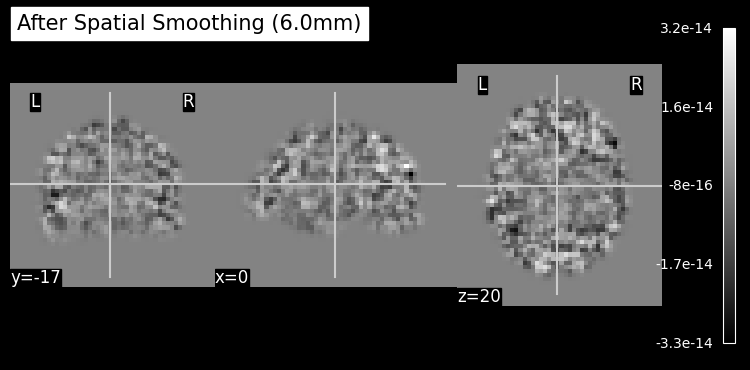

In [13]:
plotting.plot_epi(image.mean_img(smoothed_img), title=f"After Spatial Smoothing ({fwhm}mm)", cmap="gray")
plt.show()

### 6. Summary Comparison (Raw vs Fully Preprocessed)
To see the total impact, we visualize the difference map.

/var/folders/4w/jb7nh9ns51vcx_1p3nn151800000gn/T/ipykernel_4898/268306497.py:2: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  diff_data = image.mean_img(fmri_img).get_fdata() - image.mean_img(smoothed_img).get_fdata()


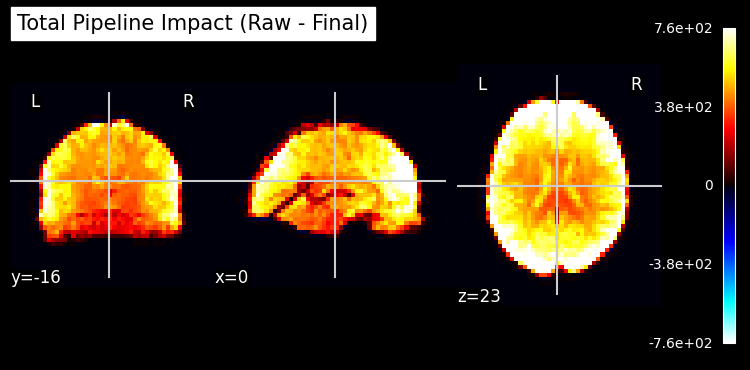

In [14]:
# Compute difference between raw mean and final processed mean
diff_data = image.mean_img(fmri_img).get_fdata() - image.mean_img(smoothed_img).get_fdata()
diff_img = nib.Nifti1Image(diff_data, fmri_img.affine)

# Plotting the "Noise" and "Blur" removed/added by the pipeline
vmax = np.percentile(np.abs(diff_data), 98)
plotting.plot_epi(diff_img, title="Total Pipeline Impact (Raw - Final)", 
                  vmin=-vmax, vmax=vmax, cmap="cold_hot", colorbar=True)
plt.show()